In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

In [2]:
# Importing test data
X_df = pd.read_csv("/workspace/anomaly_lte/data/x_test_processed_ft2.csv")

X_df = X_df.iloc[:,1:]

In [3]:
# Importing decision tree model
with open('models/train_dtree_ft2.pkl', 'rb') as model_file:
    dtree = pickle.load(model_file)

In [4]:
# Setting up SHAP explainer
explainer = shap.TreeExplainer(dtree, X_df)
shap_values = explainer.shap_values(X_df)

# Turning plot unicolor (not splitting into two classes)
shap_values = shap_values[0] * 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


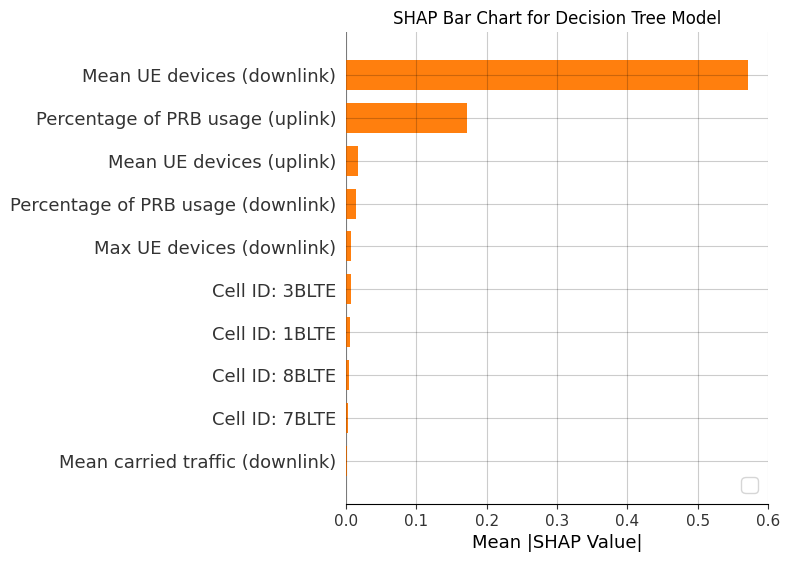

In [5]:
# Plotting Summary plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_df, plot_type='bar', show=False, color="C1", max_display=10)
ax.grid(color='black', alpha = 0.2)
legend = ax.legend(fontsize=15, loc = "lower right")
ax.set_xlabel("Mean |SHAP Value|")
ax.set_title("SHAP Bar Chart for Decision Tree Model")
plt.show()